In [1]:
from sklearn.model_selection import train_test_split
#from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
#from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [2]:
df1 = pd.read_csv("challenge1.csv")
# df = pd.read_csv("UJIndoorLoc/trainingData.csv")

In [3]:
# df = df1.drop(['Unnamed: 0'], axis=1)

In [4]:
# df_dummy = pd.get_dummies(df1, columns=['FLOOR'])

## Process data

In [5]:
categories=['Floor_0', 'Floor_1','Floor_2','Floor_3','Floor_4' ]
df1.loc[:,'FLOOR'] = df1.loc[:,'FLOOR'].astype('category', categories).cat.codes

In [6]:
categories=['0.0', '1.0','2.0']
df1.loc[:,'BUILDINGID'] = df1.loc[:,'BUILDINGID'].astype('category', categories).cat.codes

In [7]:
# type(df1.USERID[0])

In [8]:
df_nan = df1.replace(100, np.nan)

In [9]:
df_new = df_nan.iloc[:, 1:521]
df1 = df_new.dropna(axis=1, how='all', thresh=None, subset=None, inplace=False)

In [10]:
df2 = df1.dropna(axis=0, how='all', thresh=None, subset=None, inplace=False)

In [11]:
df2.shape

(19861, 465)

In [12]:
df_second = df_nan.iloc[df2.index.tolist()].iloc[:, 521:] ### contains labels

In [13]:
df_target = df_second.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

In [14]:
df_target['FLOOR'][df_target['FLOOR'] == -1] = 4

In [15]:
df_target['BUILDINGID'][df_target['BUILDINGID'] == -1] = 1

In [16]:
df_train = df2.loc[df_target.index.tolist(),:]

In [17]:
df_work = df_train.fillna(-110) #try other values
df_work.to_csv("file_name", sep='\t')

In [18]:
df_work.shape

(18876, 465)

In [19]:
df_target.to_csv("file_name_target", sep='\t')

In [20]:
scaler = StandardScaler()
df_target['LATITUDE11'] = scaler.fit_transform(df_target[["LATITUDE"]])

In [21]:
df_target['LONGITUDE11'] = scaler.fit_transform(df_target[["LONGITUDE"]])

## Data exploration

In [22]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

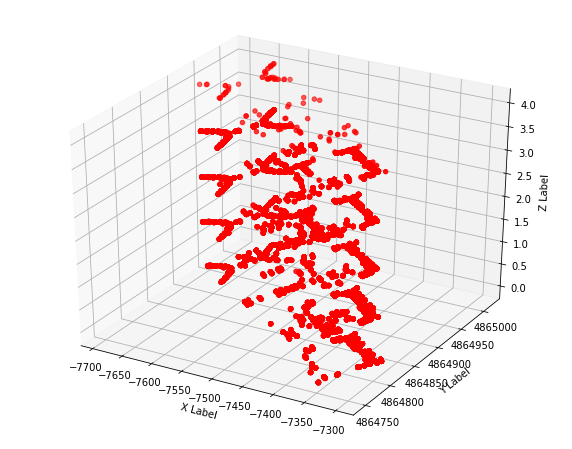

In [23]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

x =df_target.LONGITUDE
y =df_target.LATITUDE
z =df_target.FLOOR



ax.scatter(x, y, z, c='r', marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

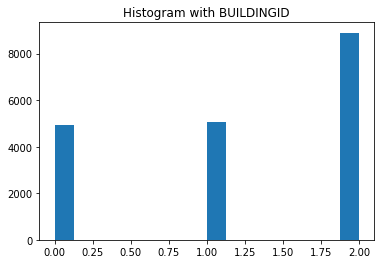

In [24]:
plt.hist(df_target.BUILDINGID, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with BUILDINGID")
plt.show()

In [25]:
df_target.groupby('BUILDINGID').size()

BUILDINGID
0    4939
1    5042
2    8895
dtype: int64

In [26]:
df_target['BUILDINGID'].corr(df_target['USERID'])

0.33925508576154434

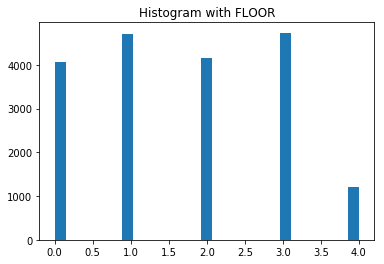

In [27]:
plt.hist(df_target.FLOOR, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with FLOOR")
plt.show()

In [28]:
df_target.groupby('FLOOR').size()

FLOOR
0    4071
1    4714
2    4155
3    4732
4    1204
dtype: int64

In [29]:
df_target['FLOOR'].corr(df_target['USERID'])

-0.18152613075336774

# Models

### Building prediction

In [30]:
data_dmatrix = xgb.DMatrix(data = df_work, label = df_target.BUILDINGID)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(df_work, df_target, test_size=0.33, random_state=42)

In [32]:
xg_train = xgb.DMatrix(X_train, label=y_train.BUILDINGID)
xg_test = xgb.DMatrix(X_test, label=y_test.BUILDINGID)

In [33]:
# setup parameters for xgboost
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softmax'
# scale weight of positive examples
param['eta'] = 0.1
param['max_depth'] = 6
param['silent'] = 1
param['nthread'] = 4
param['num_class'] = 3

watchlist = [(xg_train, 'train'), (xg_test, 'test')]
num_round = 150

In [34]:
bst = xgb.train(param, xg_train, num_round, watchlist)

[0]	train-merror:0.026174	test-merror:0.032263
[1]	train-merror:0.024593	test-merror:0.030498
[2]	train-merror:0.024593	test-merror:0.030498
[3]	train-merror:0.020797	test-merror:0.025682
[4]	train-merror:0.013285	test-merror:0.018138
[5]	train-merror:0.010913	test-merror:0.01573
[6]	train-merror:0.01028	test-merror:0.01557
[7]	train-merror:0.010043	test-merror:0.015088
[8]	train-merror:0.009964	test-merror:0.014928
[9]	train-merror:0.009173	test-merror:0.014446
[10]	train-merror:0.008777	test-merror:0.013804
[11]	train-merror:0.008936	test-merror:0.014446
[12]	train-merror:0.00941	test-merror:0.014446
[13]	train-merror:0.008857	test-merror:0.013804
[14]	train-merror:0.009252	test-merror:0.014125
[15]	train-merror:0.008382	test-merror:0.013483
[16]	train-merror:0.008619	test-merror:0.013644
[17]	train-merror:0.008303	test-merror:0.013323
[18]	train-merror:0.008145	test-merror:0.013162
[19]	train-merror:0.008145	test-merror:0.013162
[20]	train-merror:0.008145	test-merror:0.013162
[21]	t

In [35]:
# get prediction
pred = bst.predict(xg_test)

In [36]:
error_rate = np.sum(pred != y_test.BUILDINGID) / y_test.BUILDINGID.shape[0]
print('Test error = {}'.format(error_rate))

Test error = 0.011396468699839487


In [37]:
df_cm = confusion_matrix(pred, y_test.BUILDINGID)

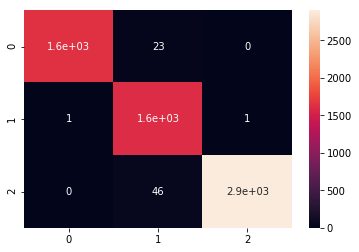

In [38]:
sb.heatmap(df_cm, annot=True)

### Floor Pred

In [39]:
data_dmatrix_Floor = xgb.DMatrix(data = df_work, label = df_target.FLOOR)

In [40]:
param['num_class'] = 5

In [41]:
num_round = 150

In [42]:
#X_train, X_test, y_train, y_test = train_test_split(df_work, df_target, test_size=0.33, random_state=42)

In [43]:
xg_train_floor = xgb.DMatrix(X_train, label=y_train.FLOOR)
xg_test_floor = xgb.DMatrix(X_test, label=y_test.FLOOR)

In [44]:
param['objective'] = 'multi:softprob'
bst_floor = xgb.train(param, xg_train_floor, num_round, watchlist)


[0]	train-merror:0.740313	test-merror:0.730819
[1]	train-merror:0.738494	test-merror:0.726645
[2]	train-merror:0.760399	test-merror:0.743339
[3]	train-merror:0.76538	test-merror:0.748475
[4]	train-merror:0.781512	test-merror:0.767095
[5]	train-merror:0.777795	test-merror:0.760995
[6]	train-merror:0.775818	test-merror:0.761637
[7]	train-merror:0.774237	test-merror:0.757624
[8]	train-merror:0.782065	test-merror:0.768058
[9]	train-merror:0.784912	test-merror:0.770626
[10]	train-merror:0.780247	test-merror:0.765811
[11]	train-merror:0.779456	test-merror:0.763403
[12]	train-merror:0.788075	test-merror:0.774478
[13]	train-merror:0.791159	test-merror:0.777689
[14]	train-merror:0.788945	test-merror:0.775281
[15]	train-merror:0.789736	test-merror:0.777368
[16]	train-merror:0.78942	test-merror:0.777368
[17]	train-merror:0.788708	test-merror:0.775762
[18]	train-merror:0.791792	test-merror:0.779294
[19]	train-merror:0.793769	test-merror:0.780738
[20]	train-merror:0.793057	test-merror:0.781059
[21]

In [45]:
pred_prob = bst_floor.predict(xg_test_floor).reshape(y_test.FLOOR.shape[0], 5)
pred_label = np.argmax(pred_prob, axis=1)
error_rate = np.sum(pred_label != y_test.FLOOR) / y_test.FLOOR.shape[0]
print('Test error using softprob = {}'.format(error_rate))

Test error using softprob = 0.013804173354735152


In [46]:
confusion_matrix(pred_label, y_test.FLOOR)

array([[1300,   10,    0,    1,   14],
       [   8, 1544,    5,    0,   10],
       [   0,    3, 1434,    2,    8],
       [   0,    1,    8, 1524,   15],
       [   0,    1,    0,    0,  342]], dtype=int64)

In [47]:
df_cm_floor = confusion_matrix(pred_label, y_test.FLOOR)

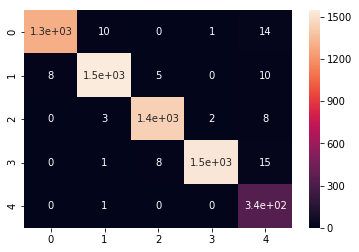

In [48]:
sb.heatmap(df_cm_floor, annot=True)

## Longitude

In [57]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.7, learning_rate = 0.1, max_depth = 8, alpha = 12, n_estimators = 150)

In [58]:
xg_reg.fit(X_train,y_train.LONGITUDE11)

preds = xg_reg.predict(X_test)

In [59]:
rmse = np.sqrt(mean_squared_error(y_test.LONGITUDE11, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.071517


## Latitude

In [60]:
xg_reg.fit(X_train,y_train.LATITUDE11)

preds = xg_reg.predict(X_test)

In [61]:
rmse = np.sqrt(mean_squared_error(y_test.LATITUDE11, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.090964
